# Импорт библиотек и загрузка данных

In [1]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score

In [2]:
data = pd.read_csv('telecom_churn.csv')

# Подготовка даных

In [3]:
data = data.drop('State', axis = 1)

In [4]:
data

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,No,Yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,68,415,No,No,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,28,510,No,No,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,184,510,Yes,No,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [5]:
#Заменим основные категориальные признаки числами
data['International plan'] = data['International plan'].map({'Yes': 1,
                                                             'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1,
                                                             'No': 0})

In [6]:
data = data.drop('Area code', axis =1).join(pd.get_dummies(data['Area code']))

## Проверим данные на выбросы

In [7]:

columns  =  ['Account length',
             'International plan',
             'Voice mail plan',
             'Total day minutes',
             'Total eve minutes',
             'Total night minutes', 'Customer service calls']

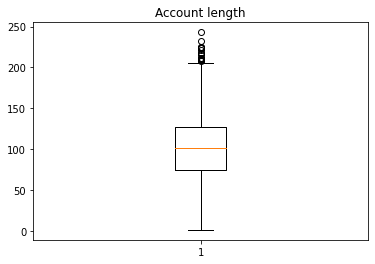

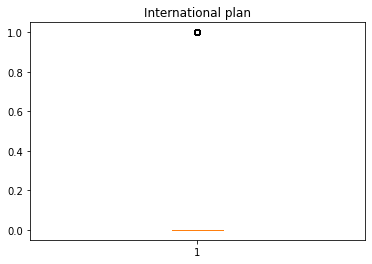

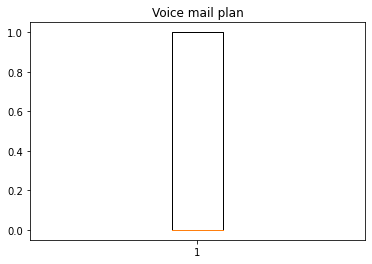

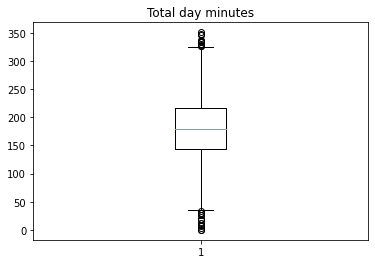

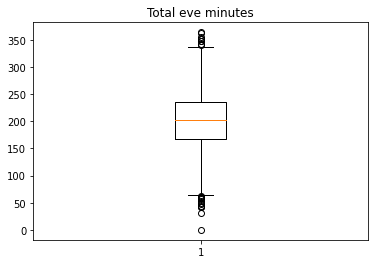

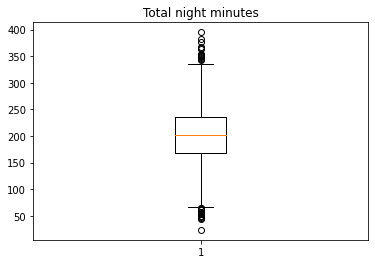

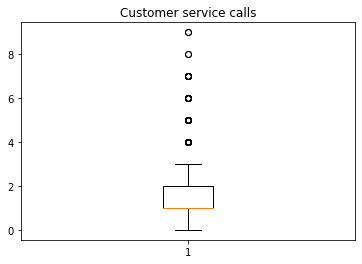

In [8]:
for f in columns:
    fig1, ax1 = plt.subplots()
    ax1.set_title(f'{f}')
    ax1.boxplot(data[f])


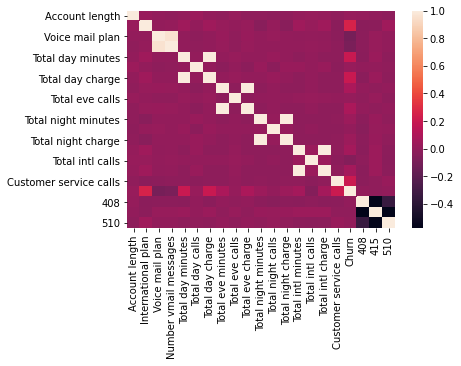

In [9]:
sns.heatmap(data.corr());

# Тест

In [10]:
second_data = data.copy()


In [11]:
data = pd.concat([data, second_data])

# Подготовка выборок

In [12]:
X = data.drop('Churn', axis = 1)
Y = data['Churn']

In [13]:
X.shape, Y.shape

((6666, 20), (6666,))

# Логистическая регрессия без подбора параметров

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                      test_size=0.2, 
                                                      random_state=42)

In [15]:
model = LogisticRegression()
# обучите модель
model.fit(X_train, y_train)

/Library/Python/3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [16]:
# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [17]:
f1_score(y_test, predictions)

0.0849056603773585

Очень грустно. 

In [18]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

In [19]:
X_test_st = scaler.transform(X_test)

In [20]:
model = LogisticRegression()
# обучите модель
model.fit(X_train_st, y_train)

LogisticRegression()

In [21]:
# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

In [22]:
f1_score(y_test, predictions)

0.32824427480916035

После стандартизации не так грустно, но все еще паршиво. 

# Подбор оптимальных параметров для модели

In [23]:
c_values = list(np.arange(0.1, 15, 0.2))
param_grid = [
    {'C': c_values, 
     'penalty': ['l2'], 
     'solver' : ['liblinear'], 
     'multi_class' : ['ovr'],
    'class_weight':['balanced']}]
     

In [24]:
np.arange(0.1, 10, 0.2)

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9, 5.1,
       5.3, 5.5, 5.7, 5.9, 6.1, 6.3, 6.5, 6.7, 6.9, 7.1, 7.3, 7.5, 7.7,
       7.9, 8.1, 8.3, 8.5, 8.7, 8.9, 9.1, 9.3, 9.5, 9.7, 9.9])

In [25]:
model = LogisticRegression()

In [26]:
grid = GridSearchCV(model, param_grid, cv = 5, scoring = 'f1')
grid.fit(X_train_st, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 0.30000000000000004, 0.5000000000000001,
                                0.7000000000000001, 0.9000000000000001,
                                1.1000000000000003, 1.3000000000000003,
                                1.5000000000000004, 1.7000000000000004,
                                1.9000000000000004, 2.1000000000000005,
                                2.3000000000000007, 2.5000000000000004,
                                2.7000000000000006, 2.900000000000001,
                                3.1000000000000005, 3.3000000000000007,
                                3.500000000000001, 3.7000000000000006,
                                3.900000000000001, 4.1000000000000005,
                                4.300000000000001, 4.500000000000001, 4.7, 4.9,
                                5.1000000000000005, 5.300000000000001,
                                5.500000000000001, 5.700000000000001, 5.9, 

In [27]:
grid.best_score_

0.48691795246855457

In [28]:
grid.best_params_

{'C': 0.5000000000000001,
 'class_weight': 'balanced',
 'multi_class': 'ovr',
 'penalty': 'l2',
 'solver': 'liblinear'}

По сути своей это угадывание, так как если всегда говорить, что клиент не уйдет от нас - результат практически аналогичный. 


## Оптимизацию можно начать с трешхолда

In [38]:
model = LogisticRegression(C= 5, class_weight=  'balanced', penalty = 'l2')

In [39]:
# обучите модель
model.fit(X_train_st, y_train)

LogisticRegression(C=5, class_weight='balanced')

In [40]:
# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

In [41]:
threshold = 0.566

In [42]:
custom_predictions = [0 if i<threshold else 1 for i in probabilities]

In [43]:
f1_score(y_test, custom_predictions)

0.492248062015504

# Случайный лес

In [35]:
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state = 42)
gb_model.fit(X_train, y_train)# обучим модель случайного леса


GradientBoostingClassifier(random_state=42)

In [36]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
gb_predictions = gb_model.predict(X_test)
gb_probabilities = gb_model.predict_proba(X_test)[:,1]


In [37]:
f1_score(y_test, gb_predictions)

0.8816568047337279